In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from datetime import datetime
import pickle
import os
import json
import seaborn as sns
import math
import torch.nn.functional as F


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class FeatureCorrelationModule(nn.Module):
    """
    A module that explicitly models feature correlations to better handle MNAR scenarios.
    """
    def __init__(self, num_features, d_model, dropout=0.1):
        super().__init__()
        self.correlation_proj = nn.Linear(d_model, d_model)
        self.feature_gate = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid()
        )
        self.correlation_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input features [batch_size, num_features, d_model]
            mask: Missing value mask [batch_size, num_features]
            
        Returns:
            Correlation-enhanced features
        """
        batch_size, num_features, d_model = x.size()
        
        # Project features for correlation computation
        x_proj = self.correlation_proj(x)
        
        # Compute pairwise feature correlations (scaled dot-product)
        corr_matrix = torch.bmm(x_proj, x_proj.transpose(1, 2)) / math.sqrt(d_model)
        
        # If we have a mask, adjust correlation for missing values
        if mask is not None:
            # Create attention mask (1 for observed values, 0 for missing)
            obs_mask = 1 - mask.float()
            mask_matrix = torch.bmm(obs_mask.unsqueeze(2), obs_mask.unsqueeze(1))
            
            # Apply mask to correlation matrix (masked positions get -1e9)
            masked_corr = corr_matrix.masked_fill(mask_matrix == 0, -1e9)
            
            # Softmax to get normalized correlation weights
            corr_weights = F.softmax(masked_corr, dim=-1)
        else:
            corr_weights = F.softmax(corr_matrix, dim=-1)
        
        # Apply correlation weights to propagate information across features
        corr_features = torch.bmm(corr_weights, x)
        
        # Compute feature-specific gates to control information flow
        gates = self.feature_gate(x)
        
        # Gate the correlation features and apply residual connection
        gated_corr = gates * corr_features
        enhanced_features = x + self.dropout(gated_corr)
        
        # Apply layer normalization
        enhanced_features = self.correlation_norm(enhanced_features)
        
        return enhanced_features

In [5]:
class FeatureValueDependentEncoder(nn.Module):
    """
    A module that explicitly models the relationship between feature values and missingness,
    which is crucial for MNAR scenarios.
    """
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        # Increase capacity of the value encoder with one more layer
        self.value_encoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout for regularization
            nn.Linear(d_model, d_model),
            nn.GELU(),  # Add one more non-linearity
            nn.Linear(d_model, d_model),  # Add one more layer
            nn.LayerNorm(d_model)
        )
        
        # Enhance missingness encoder to better capture patterns
        self.missingness_encoder = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout for regularization
            nn.Linear(d_model // 2, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Add attention mechanism for better fusion
        self.attention = nn.MultiheadAttention(d_model, num_heads=4, dropout=dropout)
        
        # Enhanced fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input features [batch_size, num_features, d_model]
            mask: Missing value mask [batch_size, num_features]
            
        Returns:
            Features with enhanced MNAR understanding
        """
        # Encode feature values
        value_encoding = self.value_encoder(x)
        
        # If we have a mask, encode missingness patterns
        if mask is not None:
            # Encode missingness (expanded to match d_model dimension)
            mask_encoding = self.missingness_encoder(mask.float().unsqueeze(-1))

            # Reshape for attention: [seq_len, batch_size, d_model]
            batch_size, num_features, d_model = value_encoding.size()
            v_enc = value_encoding.transpose(0, 1)
            m_enc = mask_encoding.transpose(0, 1)

            attn_output, _ = self.attention(m_enc, v_enc, v_enc)

            attn_output = attn_output.transpose(0, 1)

            mask_encoding = mask_encoding + attn_output
            
            combined = torch.cat([value_encoding, mask_encoding], dim=-1)
            enhanced = self.fusion_layer(combined)
        else:
            # Without mask, just use value encoding
            enhanced = value_encoding
            
        return enhanced

In [6]:
class RelativePositionEncoding(nn.Module):
    """
    Learnable relative position encoding for features in the transformer model.
    This allows the model to understand relationships between features based on their positions.
    """
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.rel_pos_embedding = nn.Parameter(torch.randn(2 * max_seq_len - 1, d_model))
        self.max_seq_len = max_seq_len
        
    def forward(self, x):
        """
        Apply relative positional encodings to the input.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            
        Returns:
            Tensor with relative positional information.
        """
        seq_len = x.size(1)
        pos_indices = torch.arange(seq_len, device=x.device)
        rel_pos_indices = pos_indices.unsqueeze(1) - pos_indices.unsqueeze(0) + self.max_seq_len - 1
        rel_pos_encoded = self.rel_pos_embedding[rel_pos_indices]
        
        return rel_pos_encoded

In [7]:
class MultiHeadAttentionWithRelPos(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    """
    def __init__(self, d_model, num_heads, dropout=0.1, max_seq_len=1000):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        self.rel_pos_encoding = RelativePositionEncoding(max_seq_len, d_model)
        
        self.rel_pos_proj = nn.Linear(d_model, d_model)

        self.scale = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, key_padding_mask=None, need_weights=False):
        """
        Forward pass with relative positional encoding.
        
        Args:
            query, key, value: Input tensors [batch_size, seq_len, d_model]
            key_padding_mask: Mask for padded values [batch_size, seq_len]
            need_weights: Whether to return attention weights
            
        Returns:
            Output tensor and optionally attention weights
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        #Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        #content-based attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [batch, heads, seq_len, seq_len]
        
        rel_bias = torch.zeros((seq_len, seq_len), device=query.device)
        positions = torch.arange(seq_len, device=query.device)
        relative_positions = positions.unsqueeze(1) - positions.unsqueeze(0)

        rel_bias = -torch.abs(relative_positions) * 0.1

        attn_scores = attn_scores + rel_bias.unsqueeze(0).unsqueeze(0)

        if key_padding_mask is not None:
            attn_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            attn_scores = attn_scores.masked_fill(attn_mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.out_proj(output)
        
        if need_weights:
            return output, attn_weights
        else:
            return output


In [8]:
class RelativePositionTransformerLayer(nn.Module):
    """
    Transformer encoder layer with relative positional encoding.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, 
                 activation="gelu", max_seq_len=1000, norm_first=True):
        super().__init__()

        self.self_attn = MultiHeadAttentionWithRelPos(
            d_model, nhead, dropout=dropout, max_seq_len=max_seq_len
        )

        #FFN
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        #Activation
        self.activation = getattr(nn.functional, activation)
        self.norm_first = norm_first
        
    def forward(self, src, src_key_padding_mask=None):
        """
        Forward pass of the transformer layer.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            src_key_padding_mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Processed tensor
        """
        # Pre-norm architecture
        if self.norm_first:
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2, key_padding_mask=src_key_padding_mask)
            src = src + self.dropout1(src2)
            
            src2 = self.norm2(src)
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
            src = src + self.dropout2(src2)
        else:
            # Multi-head attention block with post-normalization
            src2 = self.self_attn(src, src, src, key_padding_mask=src_key_padding_mask)
            src = self.norm1(src + self.dropout1(src2))
            
            # Feedforward block with post-normalization
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
            src = self.norm2(src + self.dropout2(src2))
            
        return src

In [9]:
class RelativePositionTransformerEncoder(nn.Module):
    """
    Transformer encoder with relative positional encoding.
    """
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        
    def forward(self, src, mask=None):
        """
        Forward pass of the transformer encoder.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Encoded tensor
        """
        output = src
        for layer in self.layers:
            output = layer(output, src_key_padding_mask=mask)
        return output

In [10]:
class TabularTransformerWithRelPos(nn.Module):
    """
    Enhanced transformer model for tabular data imputation with improved
    MNAR handling through correlation modeling.
    """
    def __init__(self, 
                 num_features, 
                 d_model=128, 
                 nhead=8, 
                 num_layers=3, 
                 dim_feedforward=512, 
                 dropout=0.1, 
                 activation='gelu',
                 max_seq_len=1000):
        super().__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        self.missing_embedding = nn.Parameter(torch.randn(1, d_model))
        
        self.feature_correlation = FeatureCorrelationModule(num_features, d_model, dropout)
        
        self.feature_value_encoder = FeatureValueDependentEncoder(d_model, dropout)
        
        self.norm = nn.LayerNorm(d_model)
        
        encoder_layer = RelativePositionTransformerLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            max_seq_len=max_seq_len,
            norm_first=True
        )
        
        # Create transformer encoder
        self.transformer_encoder = RelativePositionTransformerEncoder(encoder_layer, num_layers)

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Kaiming initialization for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                
    def _generate_attention_mask(self, mask):
        """Generate attention mask for transformer"""
        if mask is None:
            return None
        attn_mask = mask.bool()
        return attn_mask
                
    def forward(self, x, column_indices, mask=None):
        """
        Forward pass with enhanced correlation modeling for MNAR patterns.
        
        Args:
            x: Input tensor [batch_size, num_features]
            column_indices: Tensor of column indices [num_features]
            mask: Optional mask for missing values [batch_size, num_features]
            
        Returns:
            Tensor of predicted values [batch_size, num_features]
        """
        batch_size = x.size(0)

        x = x.unsqueeze(-1)

        x_embedded = self.value_embedding(x)

        col_embed = self.column_embedding(column_indices).unsqueeze(0).expand(batch_size, -1, -1)
        x_embedded = x_embedded + col_embed

        if mask is not None:

            mask_expanded = mask.unsqueeze(-1).expand_as(x_embedded)
            missing_embed = self.missing_embedding.expand_as(x_embedded)
            x_embedded = torch.where(mask_expanded == 1, missing_embed, x_embedded)
        
        x_correlated = self.feature_correlation(x_embedded, mask)
        
        x_value_aware = self.feature_value_encoder(x_correlated, mask)
        
        x_embedded = self.norm(x_value_aware)
        
        attn_mask = self._generate_attention_mask(mask) if mask is not None else None
        x_encoded = self.transformer_encoder(x_embedded, attn_mask)
        
        output = self.output_projection(x_encoded).squeeze(-1)
        
        return output

In [11]:
class EnsembleModel(nn.Module):
    """
    Ensemble of transformer models for improved prediction.
    """
    def __init__(self, num_features, config, num_models=3):
        super().__init__()
        self.num_models = num_models
        
        # Create multiple base models
        self.models = nn.ModuleList([
            TabularTransformerWithRelPos(
                num_features=num_features,
                d_model=config["d_model"],
                nhead=config["num_heads"],
                num_layers=config["num_layers"],
                dim_feedforward=config["dim_feedforward"],
                dropout=config["dropout"],
                activation=config["activation"],
                max_seq_len=max(2 * num_features, 100)
            ) for _ in range(num_models)
        ])
        
    def forward(self, x, column_indices, mask=None):
        # Get predictions from all models
        all_preds = []
        for model in self.models:
            preds = model(x, column_indices, mask)
            all_preds.append(preds.unsqueeze(0))
        
        # Stack and average predictions
        all_preds = torch.cat(all_preds, dim=0)
        avg_preds = torch.mean(all_preds, dim=0)
        
        return avg_preds

In [12]:
def create_missing_mask(data, missing_fraction=0.2, mechanism="MCAR"):
    """
    Create a mask for missing values using different mechanisms.
    
    Args:
        data (torch.Tensor): Input data tensor
        missing_fraction (float): Fraction of values to mask
        mechanism (str): One of "MCAR", "MAR", or "MNAR"
        
    Returns:
        torch.Tensor: Binary mask (1 = missing, 0 = present)
    """
    try:
  
        if mechanism == "MCAR":
            mask = torch.rand(data.shape, device=data.device) < missing_fraction
            return mask.int()
 
        elif mechanism == "MAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # Number of features
            num_features = data.shape[1]

            for col_idx in range(num_features):
               
                predictor_col = (col_idx + 1) % num_features
                
                # Get predictor values
                predictor_values = data[:, predictor_col]
                
                if predictor_values.max() > predictor_values.min():
                    normalized_values = (predictor_values - predictor_values.min()) / (predictor_values.max() - predictor_values.min())
                else:
                    normalized_values = torch.zeros_like(predictor_values)
                

                prob = normalized_values * 0.5 + torch.rand(data.shape[0], device=data.device) * 0.5
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Simulated MNAR (missing not at random) implementation
        # In MNAR, missingness depends on the missing values themselves
        elif mechanism == "MNAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # For each column, make missingness depend on its own values
            for col_idx in range(data.shape[1]):
                # Get column values
                col_values = data[:, col_idx]
                
                # Normalize values to [0, 1] range
                if col_values.max() > col_values.min():
                    normalized_values = (col_values - col_values.min()) / (col_values.max() - col_values.min())
                else:
                    normalized_values = torch.zeros_like(col_values)
                
                # For MNAR, higher values have higher probability of being missing
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.7 + torch.rand(data.shape[0], device=data.device) * 0.3
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Default to MCAR if unknown mechanism
        else:
            print(f"Unknown missing data mechanism: {mechanism}. Defaulting to MCAR.")
            return create_missing_mask(data, missing_fraction, "MCAR")
            
    except Exception as e:
        print(f"Error creating {mechanism} mask: {e}")
        # Fall back to MCAR if there's an error
        return create_missing_mask(data, missing_fraction, "MCAR")

In [13]:
def load_and_prepare_data(data_path, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Load and prepare data for model training.
    
    Args:
        data_path (str): Path to the CSV file
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed train, validation, test tensors, scaler, and column indices
    """
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path, index_col=None)
    
    # Check for missing values
    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: Dataset contains {missing_count} missing values. These will be handled in preprocessing.")
        # Simple imputation for missing values
        df = df.fillna(df.mean())
    
    # Convert to numpy for preprocessing
    data = df.to_numpy()
    
    # Split data into train and test
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio,
        random_state=random_state
    )
    
    # Normalize data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32).to(device)
    val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32).to(device)
    test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices
    column_indices = torch.arange(train_tensor.shape[1]).to(device)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of training samples: {train_tensor.shape[0]}")
    print(f"Number of validation samples: {val_tensor.shape[0]}")
    print(f"Number of test samples: {test_tensor.shape[0]}")
    print(f"Number of features: {train_tensor.shape[1]}")
    
    return train_tensor, val_tensor, test_tensor, scaler, column_indices

In [14]:
def compute_mnar_weighted_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute loss with sophisticated weighting for MNAR scenarios based on
    feature correlations and value magnitudes.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        mechanism (str): Missing data mechanism (MCAR, MAR, MNAR)
        
    Returns:
        torch.Tensor: Weighted loss
    """
    batch_size, num_features = ground_truth.shape
    mse_loss = nn.MSELoss(reduction='none')
    element_loss = mse_loss(predictions, ground_truth)
    
    if mechanism == "MNAR":
        base_weight = 2.0
    elif mechanism == "MAR":
        base_weight = 1.2
    else:  # MCAR
        base_weight = 1.0
    
    if mechanism == "MNAR":

        observed_mask = 1 - mask
        
        feature_means = torch.zeros_like(ground_truth)
        for i in range(num_features):
            feat_observed = ground_truth[:, i] * observed_mask[:, i]
            feat_count = observed_mask[:, i].sum() + 1e-8
            feat_mean = feat_observed.sum() / feat_count
            feature_means[:, i] = feat_mean

        abs_deviation = torch.abs(ground_truth - feature_means)

        max_devs = abs_deviation.max(dim=0, keepdim=True)[0]
        min_devs = abs_deviation.min(dim=0, keepdim=True)[0]
        range_devs = max_devs - min_devs + 1e-8
        norm_deviation = (abs_deviation - min_devs) / range_devs
        
        # Higher deviations get higher weights (values far from mean are harder to predict in MNAR)
        # This captures the dependency between the value itself and its missingness
        value_weights = 1.0 + norm_deviation * 1.5

        weights = base_weight * mask * value_weights
    else:

        weights = base_weight * mask

    weighted_loss = (element_loss * weights).sum() / (weights.sum() + 1e-8)
    
    return weighted_loss

In [15]:
def compute_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute loss using the enhanced MNAR-weighted loss function.
    """
    return compute_mnar_weighted_loss(predictions, ground_truth, mask, mechanism)

In [16]:
def compute_rmse(predictions, ground_truth, mask):
    """
    Compute Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: RMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [17]:
def compute_nrmse(predictions, ground_truth, mask):
    """
    Compute Normalized Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: NRMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

In [18]:
def train_epoch(model, dataloader, optimizer, missing_fraction, mechanisms=None, scheduler=None, accumulation_steps=4):
    """
    Train for one epoch with gradient accumulation, mixup data augmentation and gradient clipping.
    
    Args:
        model (nn.Module): Model to train
        dataloader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        scheduler (LRScheduler, optional): Learning rate scheduler
        accumulation_steps (int): Number of steps to accumulate gradients
        
    Returns:
        dict: Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    
    # Mixup probability
    mixup_prob = 0.3
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    progress_bar = tqdm(dataloader, desc="Training")
    optimizer.zero_grad()  # Zero gradients at the beginning
    
    for i, batch in enumerate(progress_bar):
        x = batch[0].to(device)
        
        mechanism = random.choice(mechanisms)
        
        # Create a mask for missing values
        mask = create_missing_mask(x, missing_fraction, mechanism)
        
        # Create input with missing values set to 0
        x_masked = x.clone()
        x_masked[mask == 1] = 0
        
        # Apply mixup with probability
        if random.random() < mixup_prob:
            # Create shuffled indices
            indices = torch.randperm(x.size(0), device=device)
            
            # Mix up samples with lambda drawn from beta distribution
            lam = np.random.beta(0.2, 0.2)
            
            # Mix the data
            mixed_x = lam * x_masked + (1 - lam) * x_masked[indices]
            mixed_mask = mask | mask[indices]  # Union of masks
            
            # Forward pass with mixed data
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(mixed_x, column_indices, mixed_mask)
            
            # Compute mixed loss
            loss = lam * compute_loss(predictions, x, mask, mechanism) + \
                   (1 - lam) * compute_loss(predictions, x[indices], mask[indices], mechanism)
        else:
            # Standard forward pass
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(x_masked, column_indices, mask)
            
            # Compute loss
            loss = compute_loss(predictions, x, mask, mechanism)
        
        # Scale loss by accumulation steps   
        loss = loss / accumulation_steps
            
        # Backward pass
        loss.backward()
        
        # Only step optimizer and scheduler after accumulation
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            # Add gradient clipping (reduced for stability)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
            optimizer.step()
            
            if scheduler is not None:
                scheduler.step()
                
            optimizer.zero_grad()
        
        # Update progress bar
        total_loss += loss.item() * accumulation_steps  # Scale back for reporting
        progress_bar.set_postfix({"loss": loss.item() * accumulation_steps})
    
    avg_loss = total_loss / len(dataloader)
    return {"loss": avg_loss}

In [19]:
def validate(model, dataloader, missing_fraction, mechanisms=None):
    """
    Validate the model on all mechanisms.
    
    Args:
        model (nn.Module): Model to validate
        dataloader (DataLoader): Validation data loader
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        
    Returns:
        dict: Dictionary with validation metrics
    """
    model.eval()
    total_loss = 0
    total_rmse = 0
    total_nrmse = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    mechanism_metrics = {m: {"loss": 0, "rmse": 0, "nrmse": 0, "count": 0} for m in mechanisms}
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            
            for mechanism in mechanisms:
                # Create a mask for missing values
                mask = create_missing_mask(x, missing_fraction, mechanism)
                
                # Create input with missing values set to 0
                x_masked = x.clone()
                x_masked[mask == 1] = 0
                
                # Forward pass
                column_indices = torch.arange(x.shape[1], device=device)
                predictions = model(x_masked, column_indices, mask)
                
                # Compute metrics
                loss = compute_loss(predictions, x, mask)
                rmse = compute_rmse(predictions, x, mask)
                nrmse = compute_nrmse(predictions, x, mask)
                
                # Update mechanism-specific metrics
                mechanism_metrics[mechanism]["loss"] += loss.item()
                mechanism_metrics[mechanism]["rmse"] += rmse
                mechanism_metrics[mechanism]["nrmse"] += nrmse
                mechanism_metrics[mechanism]["count"] += 1
                
                # Update overall metrics
                total_loss += loss.item()
                total_rmse += rmse
                total_nrmse += nrmse
    
    # Calculate averages
    num_evaluations = len(dataloader) * len(mechanisms)
    avg_loss = total_loss / num_evaluations
    avg_rmse = total_rmse / num_evaluations
    avg_nrmse = total_nrmse / num_evaluations
    
    # Calculate mechanism-specific averages
    for m in mechanisms:
        if mechanism_metrics[m]["count"] > 0:
            mechanism_metrics[m]["loss"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["rmse"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["nrmse"] /= mechanism_metrics[m]["count"]
    
    return {
        "loss": avg_loss,
        "rmse": avg_rmse,
        "nrmse": avg_nrmse,
        "mechanisms": mechanism_metrics
    }

In [20]:
def plot_training_history(history, save_path=None):
    """
    Plot training history.
    
    Args:
        history (dict): Training history
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(20, 12))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot NRMSE
    plt.subplot(2, 2, 2)
    plt.plot(history["val_nrmse"], label="Overall NRMSE")
    plt.plot(history["val_mcar_nrmse"], label="MCAR NRMSE")
    plt.plot(history["val_mar_nrmse"], label="MAR NRMSE")
    plt.plot(history["val_mnar_nrmse"], label="MNAR NRMSE")
    plt.title("NRMSE by Mechanism")
    plt.xlabel("Epoch")
    plt.ylabel("NRMSE")
    plt.legend()
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.tight_layout()
    plt.show()

In [21]:
def save_model(model, scaler, config, save_dir="models"):
    """
    Save model and related objects.
    
    Args:
        model (nn.Module): Trained model
        scaler (StandardScaler): Data scaler
        config (dict): Model configuration
        save_dir (str): Directory to save model
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "tabular_transformer_relpos.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, model_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

In [22]:
def train_model(train_data, val_data, column_indices, config, model_type="single"):
    """
    Train the model (single model or ensemble).
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model based on type
    num_features = train_data.shape[1]
    
    if model_type == "ensemble":
        print("Creating ensemble model with 3 base models...")
        model = EnsembleModel(
            num_features=num_features,
            config=config,
            num_models=3
        ).to(device)
    else:
        print("Creating single transformer model...")
        model = TabularTransformerWithRelPos(
            num_features=num_features,
            d_model=config["d_model"],
            nhead=config["num_heads"],
            num_layers=config["num_layers"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["dropout"],
            activation=config["activation"],
            max_seq_len=max(2 * num_features, 100)  # Set max_seq_len based on feature count
        ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    accumulation_steps = config.get("accumulation_steps", 4)
    
    # Learning rate scheduler - use OneCycleLR for better convergence
    total_steps = (len(train_dataloader) // accumulation_steps) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.1,  # Shorter warm-up phase
        anneal_strategy='cos',
        div_factor=10.0,  # Less aggressive initial LR reduction
        final_div_factor=1000.0  # Less aggressive final LR
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_nrmse": [],
        "val_mcar_nrmse": [],
        "val_mar_nrmse": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
            accumulation_steps=config.get("accumulation_steps", 4)
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_nrmse"].append(val_metrics["nrmse"])
        history["val_mcar_nrmse"].append(val_metrics["mechanisms"]["MCAR"]["nrmse"])
        history["val_mar_nrmse"].append(val_metrics["mechanisms"]["MAR"]["nrmse"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val NRMSE: {val_metrics['nrmse']:.4f}")
        print(f"Val MCAR NRMSE: {val_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"Val MAR NRMSE: {val_metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [23]:
def cross_validate_model(data, column_indices, config, n_folds=5, model_type="single"):
    """
    Perform k-fold cross-validation.
    
    Args:
        data (torch.Tensor): Data to split
        column_indices (torch.Tensor): Feature column indices
        config (dict): Configuration dictionary
        n_folds (int): Number of folds
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        dict: Dictionary with average metrics across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    all_metrics = []
    all_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"\nTraining fold {fold+1}/{n_folds}")
        
        # Split data
        train_data = data[train_idx]
        val_data = data[val_idx]
        
        # Train model (can be single or ensemble based on model_type)
        model, history = train_model(train_data, val_data, column_indices, config, model_type=model_type)
        
        # Store model
        all_models.append(model)
        
        # Validate
        val_dataloader = DataLoader(TensorDataset(val_data), batch_size=config["batch_size"])
        metrics = validate(model, val_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
        
        all_metrics.append(metrics)
        
        print(f"Fold {fold+1} metrics:")
        print(f"  NRMSE: {metrics['nrmse']:.4f}")
        print(f"  MCAR NRMSE: {metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"  MAR NRMSE: {metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"  MNAR NRMSE: {metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Average metrics across folds
    avg_metrics = {
        "nrmse": np.mean([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse": np.mean([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse": np.mean([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse": np.mean([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Standard deviation of metrics
    std_metrics = {
        "nrmse_std": np.std([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse_std": np.std([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse_std": np.std([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse_std": np.std([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Add standard deviations to results
    avg_metrics.update(std_metrics)
    
    print("\nAverage metrics across folds:")
    print(f"  NRMSE: {avg_metrics['nrmse']:.4f} ± {avg_metrics['nrmse_std']:.4f}")
    print(f"  MCAR NRMSE: {avg_metrics['mcar_nrmse']:.4f} ± {avg_metrics['mcar_nrmse_std']:.4f}")
    print(f"  MAR NRMSE: {avg_metrics['mar_nrmse']:.4f} ± {avg_metrics['mar_nrmse_std']:.4f}")
    print(f"  MNAR NRMSE: {avg_metrics['mnar_nrmse']:.4f} ± {avg_metrics['mnar_nrmse_std']:.4f}")
    
    return avg_metrics, all_models

Loading data from ./data/physionet_39_features_only_no_leakage.csv
Dataset shape: (2008, 39)
Number of training samples: 1405
Number of validation samples: 201
Number of test samples: 402
Number of features: 39

=== Training Model ===
Starting model training...
Creating single transformer model...

Epoch 1/50


Training: 100%|██████████| 11/11 [00:01<00:00,  5.81it/s, loss=1.55]


Train Loss: 2.1174
Val Loss: 2.1322
Val NRMSE: 0.0494
Val MCAR NRMSE: 0.0513
Val MAR NRMSE: 0.0403
Val MNAR NRMSE: 0.0567
New best validation loss: 2.1322

Epoch 2/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.20it/s, loss=1.03]


Train Loss: 1.6393
Val Loss: 1.9763
Val NRMSE: 0.0464
Val MCAR NRMSE: 0.0405
Val MAR NRMSE: 0.0378
Val MNAR NRMSE: 0.0608
New best validation loss: 1.9763

Epoch 3/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.15it/s, loss=1.18]


Train Loss: 1.7192
Val Loss: 2.1671
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0649
No improvement for 1 epochs

Epoch 4/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.98it/s, loss=1.41] 


Train Loss: 1.8026
Val Loss: 2.1596
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0443
Val MAR NRMSE: 0.0452
Val MNAR NRMSE: 0.0567
No improvement for 2 epochs

Epoch 5/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.45it/s, loss=1.56]


Train Loss: 1.5169
Val Loss: 1.8636
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0329
Val MAR NRMSE: 0.0388
Val MNAR NRMSE: 0.0633
New best validation loss: 1.8636

Epoch 6/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.74it/s, loss=1.75]


Train Loss: 1.6874
Val Loss: 2.0356
Val NRMSE: 0.0477
Val MCAR NRMSE: 0.0419
Val MAR NRMSE: 0.0449
Val MNAR NRMSE: 0.0564
No improvement for 1 epochs

Epoch 7/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.89it/s, loss=3.08]


Train Loss: 1.7958
Val Loss: 1.7677
Val NRMSE: 0.0435
Val MCAR NRMSE: 0.0375
Val MAR NRMSE: 0.0352
Val MNAR NRMSE: 0.0579
New best validation loss: 1.7677

Epoch 8/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.89it/s, loss=0.752]


Train Loss: 1.6688
Val Loss: 2.0726
Val NRMSE: 0.0469
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0434
Val MNAR NRMSE: 0.0592
No improvement for 1 epochs

Epoch 9/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s, loss=1.94]


Train Loss: 1.6274
Val Loss: 1.9300
Val NRMSE: 0.0458
Val MCAR NRMSE: 0.0425
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0570
No improvement for 2 epochs

Epoch 10/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.56it/s, loss=1.88]


Train Loss: 1.3346
Val Loss: 1.6263
Val NRMSE: 0.0421
Val MCAR NRMSE: 0.0352
Val MAR NRMSE: 0.0329
Val MNAR NRMSE: 0.0583
New best validation loss: 1.6263

Epoch 11/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.75it/s, loss=0.933]


Train Loss: 1.4691
Val Loss: 2.0113
Val NRMSE: 0.0464
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0354
Val MNAR NRMSE: 0.0575
No improvement for 1 epochs

Epoch 12/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.51it/s, loss=1.28] 


Train Loss: 1.3508
Val Loss: 1.8821
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0376
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0579
No improvement for 2 epochs

Epoch 13/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.49it/s, loss=1.28]


Train Loss: 1.6958
Val Loss: 1.9556
Val NRMSE: 0.0461
Val MCAR NRMSE: 0.0391
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0572
No improvement for 3 epochs

Epoch 14/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.17it/s, loss=0.912]


Train Loss: 1.2336
Val Loss: 1.6623
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0351
Val MAR NRMSE: 0.0352
Val MNAR NRMSE: 0.0575
No improvement for 4 epochs

Epoch 15/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.06it/s, loss=1.36]


Train Loss: 1.3406
Val Loss: 1.7370
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0342
Val MNAR NRMSE: 0.0603
No improvement for 5 epochs

Epoch 16/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.81it/s, loss=0.845]


Train Loss: 1.4953
Val Loss: 2.1581
Val NRMSE: 0.0470
Val MCAR NRMSE: 0.0429
Val MAR NRMSE: 0.0403
Val MNAR NRMSE: 0.0579
No improvement for 6 epochs

Epoch 17/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s, loss=1.5] 


Train Loss: 1.4385
Val Loss: 1.6122
Val NRMSE: 0.0417
Val MCAR NRMSE: 0.0339
Val MAR NRMSE: 0.0345
Val MNAR NRMSE: 0.0566
New best validation loss: 1.6122

Epoch 18/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.11it/s, loss=0.802]


Train Loss: 1.3425
Val Loss: 1.7311
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0355
Val MNAR NRMSE: 0.0567
No improvement for 1 epochs

Epoch 19/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.54it/s, loss=1.39] 


Train Loss: 1.4897
Val Loss: 1.6644
Val NRMSE: 0.0429
Val MCAR NRMSE: 0.0343
Val MAR NRMSE: 0.0356
Val MNAR NRMSE: 0.0587
No improvement for 2 epochs

Epoch 20/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.04it/s, loss=1.44]


Train Loss: 1.5723
Val Loss: 1.7764
Val NRMSE: 0.0441
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0355
Val MNAR NRMSE: 0.0571
No improvement for 3 epochs

Epoch 21/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.18it/s, loss=0.995]


Train Loss: 1.7878
Val Loss: 2.0467
Val NRMSE: 0.0471
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0555
No improvement for 4 epochs

Epoch 22/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s, loss=1.58]


Train Loss: 1.4341
Val Loss: 2.1870
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0447
Val MAR NRMSE: 0.0428
Val MNAR NRMSE: 0.0576
No improvement for 5 epochs

Epoch 23/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=0.77] 


Train Loss: 1.3738
Val Loss: 1.6990
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0343
Val MNAR NRMSE: 0.0575
No improvement for 6 epochs

Epoch 24/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.15it/s, loss=1.88]


Train Loss: 1.6716
Val Loss: 1.8689
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0340
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0583
No improvement for 7 epochs

Epoch 25/50


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=1.56]


Train Loss: 1.2046
Val Loss: 1.8914
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0415
Val MAR NRMSE: 0.0341
Val MNAR NRMSE: 0.0589
No improvement for 8 epochs

Epoch 26/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.81it/s, loss=1.29] 


Train Loss: 1.3075
Val Loss: 2.2658
Val NRMSE: 0.0492
Val MCAR NRMSE: 0.0445
Val MAR NRMSE: 0.0436
Val MNAR NRMSE: 0.0594
No improvement for 9 epochs

Epoch 27/50


Training: 100%|██████████| 11/11 [00:01<00:00,  7.44it/s, loss=1.76]


Train Loss: 1.8834
Val Loss: 1.8445
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0344
Val MAR NRMSE: 0.0392
Val MNAR NRMSE: 0.0580
No improvement for 10 epochs
Early stopping after 27 epochs


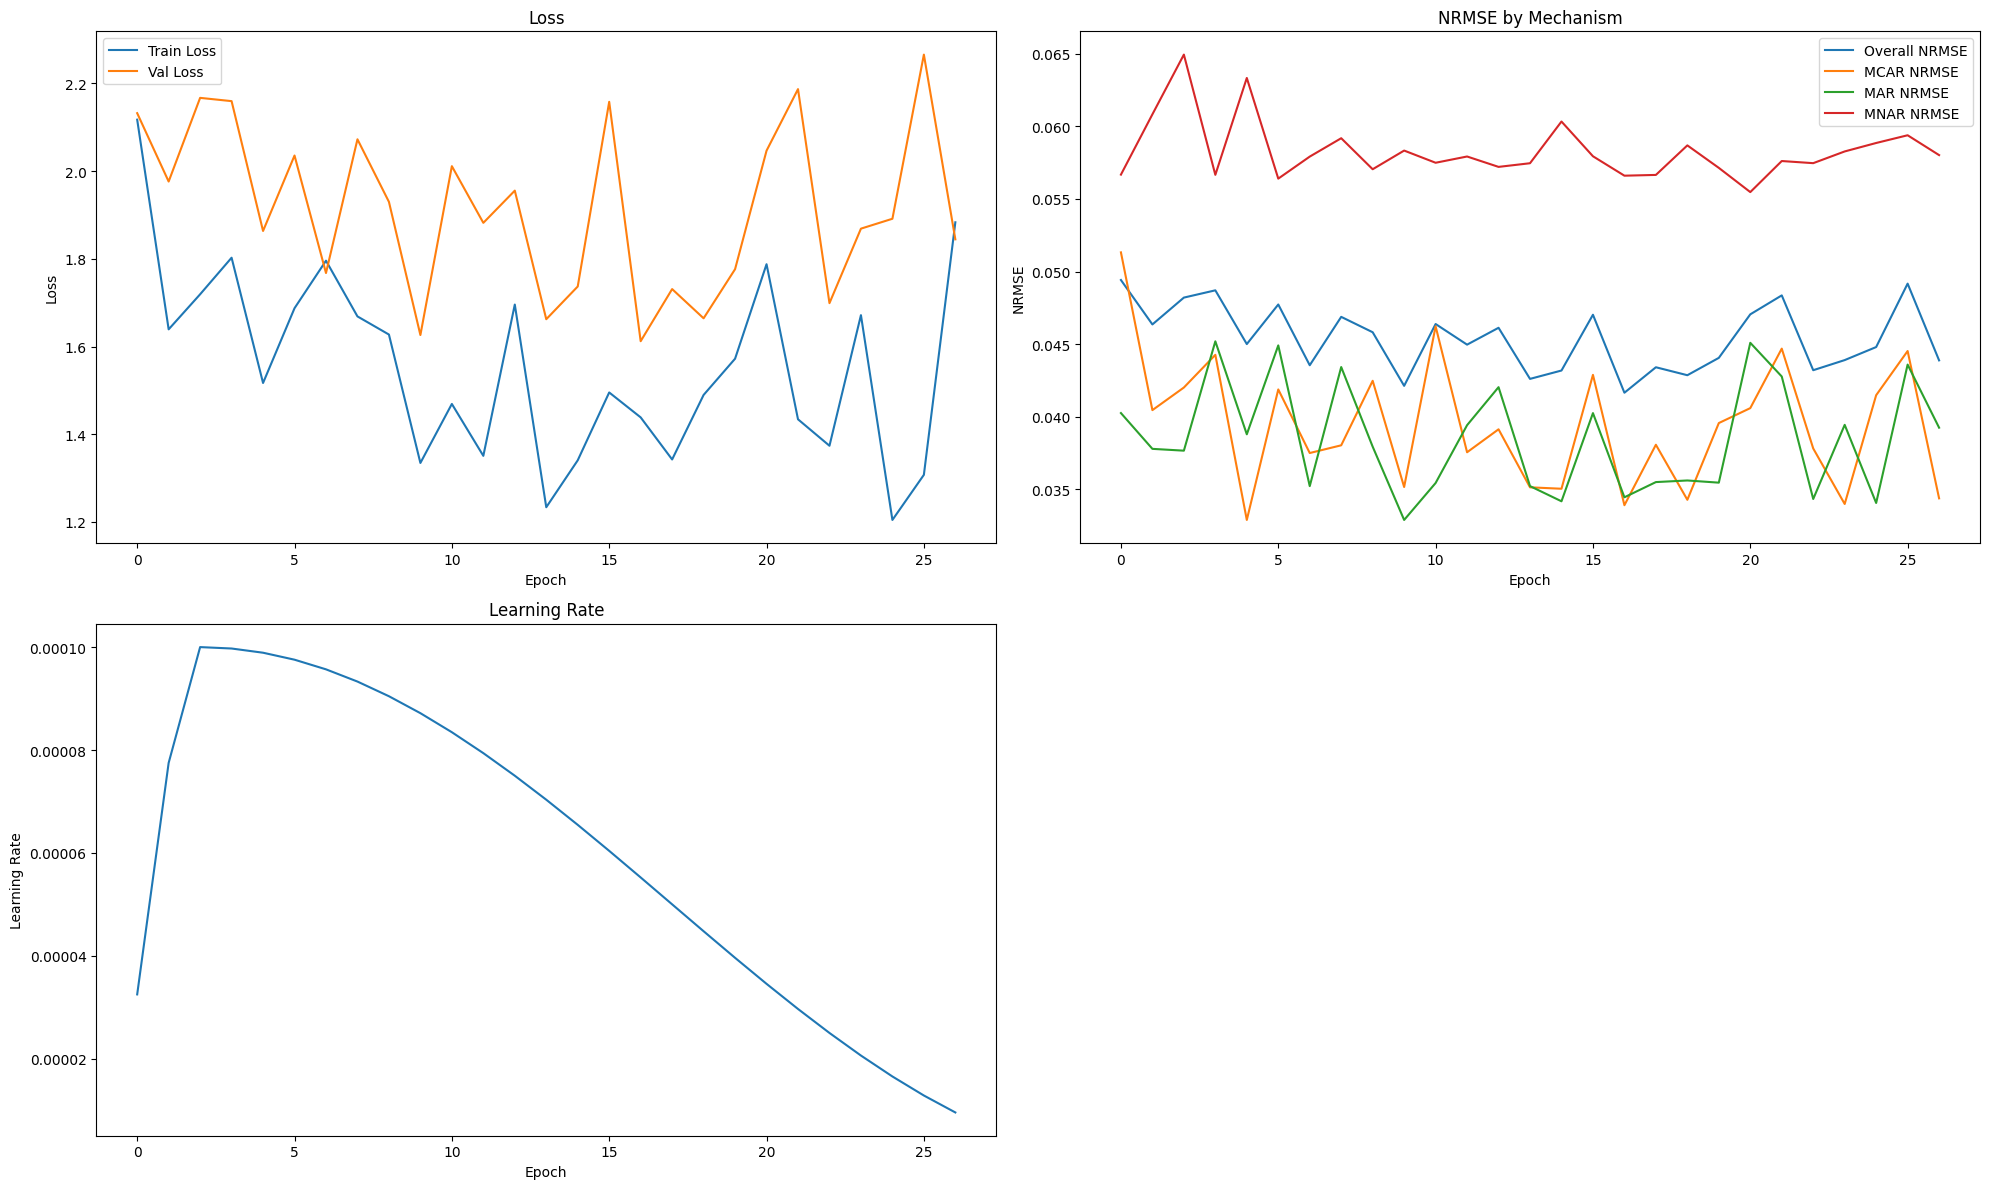


=== Evaluating on Test Set ===
Test metrics:
  Overall NRMSE: 0.0568
  MCAR NRMSE: 0.0493
  MAR NRMSE: 0.0516
  MNAR NRMSE: 0.0696

=== Saving Models ===
Training complete! All models and results saved in: models\2025-04-16_09-37-53_model-single


In [24]:
# Main execution code
if __name__ == "__main__":
    # Configuration
    config = {
        # Data parameters
        "data_path": "./data/physionet_39_features_only_no_leakage.csv",
        "test_size": 0.2,
        "val_size": 0.1,
        
        # Model parameters
        "d_model": 384,      
        "num_heads": 12, 
        "num_layers": 6, 
        "dim_feedforward": 1536,
        "dropout": 0.15,             
        "activation": "gelu",
        
        # Training parameters
        "batch_size": 128,          
        "learning_rate": 0.0001,     
        "weight_decay": 0.005,       
        "num_epochs": 50,
        "patience": 10,  
        "missing_fraction": 0.3,
        
        "warmup_steps_pct": 0.1,     # Shorter warmup phase
        "min_lr_factor": 1000.0,     # Slower final decay
        
        # Save parameters
        "save_dir": "models"
    }
    
    # Create directories with timestamp
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(config["save_dir"], f"{current_time}_model-single")
    os.makedirs(save_dir, exist_ok=True)
    
    # Create experiment log file
    experiment_log = os.path.join(save_dir, "experiment_log.txt")
    with open(experiment_log, "w") as f:
        f.write(f"Experiment started at: {current_time}\n")
        f.write("Configuration:\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
    
    # Load and prepare data
    train_data, val_data, test_data, scaler, column_indices = load_and_prepare_data(
        config["data_path"],
        config["test_size"],
        config["val_size"]
    )
    
    RUN_KFOLD = False
    
    print("\n=== Training Model ===")
    model, history = train_model(train_data, val_data, column_indices, config, model_type="single")
    
    # Plot training history
    plot_training_history(history, os.path.join(save_dir, "training_history.png"))
    
    # Evaluate on test set
    print("\n=== Evaluating on Test Set ===")
    test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
    test_metrics = validate(model, test_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
    
    print(f"Test metrics:")
    print(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}")
    print(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
    print(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}")
    print(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Save test results
    test_results_path = os.path.join(save_dir, "test_results.txt")
    with open(test_results_path, "w") as f:
        f.write("Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
    
    # Save models
    print(f"\n=== Saving Models ===")
    
    # Save final model
    model_save_path = os.path.join(save_dir, "final_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "model_type": "single"
    }, model_save_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    # Update experiment log
    with open(experiment_log, "a") as f:
        f.write("\nFinal Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        f.write(f"\nExperiment completed at: {datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

    print(f"Training complete! All models and results saved in: {save_dir}")

## Model testing

In [25]:
def evaluate_imputation_performance(model, test_data, column_indices, missing_percentages=[0.1, 0.2, 0.3, 0.4, 0.5], 
                                    mechanisms=["MCAR", "MAR", "MNAR"]):
    """
    Evaluate the model's imputation performance across different missing percentages and mechanisms.
    
    Args:
        model (nn.Module): Trained model
        test_data (torch.Tensor): Test data tensor
        column_indices (torch.Tensor): Column indices
        missing_percentages (list): List of missing data percentages to evaluate
        mechanisms (list): List of missing data mechanisms to evaluate
        
    Returns:
        pd.DataFrame: DataFrame with NRMSE results for each mechanism and percentage
    """
    model.eval()
    results = {}
    std_results = {}  # New dictionary to store standard deviations
    
    with torch.no_grad():
        for mechanism in mechanisms:
            mechanism_results = []
            mechanism_std_results = []  # New list for standard deviations
            
            for missing_pct in missing_percentages:
                batch_size = 128
                total_nrmse = 0
                num_batches = 0
                
                # Create DataLoader for test data
                test_dataloader = DataLoader(TensorDataset(test_data), batch_size=batch_size)
                
                for batch in tqdm(test_dataloader, desc=f"Evaluating {mechanism} at {missing_pct*100}%"):
                    x = batch[0].to(device)
                    
                    # Create a mask for missing values
                    mask = create_missing_mask(x, missing_pct, mechanism)
                    
                    # Create input with missing values set to 0
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Forward pass
                    predictions = model(x_masked, column_indices, mask)
                    
                    # Compute NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    total_nrmse += nrmse
                    num_batches += 1
                
                avg_nrmse = total_nrmse / num_batches
                
                # Calculate standard deviation by running multiple iterations
                all_nrmse_values = []
                # Use a smaller subset of data for the std calculation to save time
                x_subset = x[:min(len(x), 64)]  # Use up to 64 samples for std calculation
                
                # Run several iterations with different masks
                for _ in range(5):  # Run 5 iterations for standard deviation calculation
                    # Create a new mask each time
                    std_mask = create_missing_mask(x_subset, missing_pct, mechanism)
                    # Create masked input
                    std_x_masked = x_subset.clone()
                    std_x_masked[std_mask == 1] = 0
                    # Get predictions
                    std_predictions = model(std_x_masked, column_indices, std_mask)
                    # Calculate NRMSE
                    std_nrmse = compute_nrmse(std_predictions, x_subset, std_mask)
                    all_nrmse_values.append(std_nrmse)
                
                # Convert to tensor and calculate standard deviation
                std_tensor = torch.tensor(all_nrmse_values)
                std_dev = std_tensor.std().item()
                
                mechanism_results.append(avg_nrmse)
                mechanism_std_results.append(std_dev)  # Store the std deviation
                
                print(f"{mechanism} at {missing_pct*100}% missing: NRMSE = {avg_nrmse:.4f} ± {std_dev:.4f}")
            
            results[mechanism] = mechanism_results
            std_results[mechanism] = mechanism_std_results  # Store std results
    
    # Create a DataFrame for visualization
    results_df = pd.DataFrame(results, index=[f"{int(pct*100)}%" for pct in missing_percentages])
    results_df.index.name = "Missing Percentage"
    
    # Create a DataFrame for standard deviations
    std_df = pd.DataFrame(std_results, index=[f"{int(pct*100)}%" for pct in missing_percentages])
    std_df.index.name = "Missing Percentage"
    
    # Create a combined DataFrame with formatted "mean ± std" strings
    combined_df = pd.DataFrame(index=results_df.index)
    for col in results_df.columns:
        combined_df[col] = [f"{mean:.4f} ± {std:.4f}" 
                          for mean, std in zip(results_df[col], std_df[col])]
    combined_df.index.name = "Missing Percentage"
    
    # Save all DataFrames
    results_df.to_csv("nrmse_mean_values.csv")
    std_df.to_csv("nrmse_std_values.csv")
    combined_df.to_csv("nrmse_combined_values.csv")
    
    print("\nNRMSE values with standard deviation:")
    print(combined_df)
    
    return results_df  # Keep the original return value for compatibility

In [26]:
def visualize_imputation_performance(results_df, save_path=None):
    """
    Create visualizations for imputation performance.
    
    Args:
        results_df (pd.DataFrame): DataFrame with NRMSE results
        save_path (str, optional): Path to save the figures
    """
    # 1. Create a heatmap visualization
    plt.figure(figsize=(10, 6))
    
    # Create a heatmap with custom colormap (lower values = better = greener)
    sns.heatmap(results_df, annot=True, cmap="RdYlGn_r", fmt=".4f", 
                linewidths=.5, cbar_kws={'label': 'NRMSE (lower is better)'})
    
    plt.title("Imputation Performance (NRMSE) by Missing Mechanism and Percentage")
    plt.tight_layout()
    
    if save_path:
        heatmap_path = save_path.replace(".png", "_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"Heatmap saved to {heatmap_path}")
    
    plt.show()
    
    # 2. Create a line plot
    plt.figure(figsize=(12, 6))
    
    # Convert index to numeric for plotting
    results_df_plot = results_df.copy()
    results_df_plot.index = [int(idx.replace("%", "")) for idx in results_df_plot.index]
    
    # Plot lines for each mechanism
    for column in results_df_plot.columns:
        plt.plot(results_df_plot.index, results_df_plot[column], marker='o', linewidth=2, label=column)
    
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance Across Missing Percentages")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(results_df_plot.index)
    
    if save_path:
        line_path = save_path.replace(".png", "_lineplot.png")
        plt.savefig(line_path)
        print(f"Line plot saved to {line_path}")
    
    plt.show()
    
    # 3. Create a bar chart comparison
    plt.figure(figsize=(12, 6))
    
    # Plot grouped bars
    bar_width = 0.25
    r = np.arange(len(results_df_plot.index))
    
    # Plot bars for each mechanism
    for i, column in enumerate(results_df_plot.columns):
        plt.bar(r + i*bar_width, results_df_plot[column], width=bar_width, label=column)
    
    # Add labels and legend
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance by Missing Mechanism and Percentage")
    plt.xticks(r + bar_width, results_df_plot.index)
    plt.legend()
    
    if save_path:
        bar_path = save_path.replace(".png", "_barchart.png")
        plt.savefig(bar_path)
        print(f"Bar chart saved to {bar_path}")
    
    plt.show()
    
    # 4. Create a table visualization
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    ax.axis('tight')
    
    # Create a table with colored cells based on values
    # First, normalize the data for coloring
    norm_data = results_df.copy()
    for col in norm_data.columns:
        max_val = norm_data[col].max()
        min_val = norm_data[col].min()
        if max_val > min_val:
            norm_data[col] = (norm_data[col] - min_val) / (max_val - min_val)
        else:
            norm_data[col] = 0
    
    # Create a table with cell colors
    cell_colors = plt.cm.RdYlGn_r(norm_data.values)
    table = ax.table(cellText=results_df.values.round(4), 
                    rowLabels=results_df.index,
                    colLabels=results_df.columns,
                    cellColours=cell_colors,
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title("NRMSE Values by Missing Mechanism and Percentage", y=0.8)
    
    if save_path:
        table_path = save_path.replace(".png", "_table.png")
        plt.savefig(table_path, bbox_inches='tight')
        print(f"Table visualization saved to {table_path}")
    
    plt.show()
    
    return results_df


=== Evaluating Imputation Performance Across Missing Percentages ===


Evaluating MCAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 32.38it/s]


MCAR at 10.0% missing: NRMSE = 0.0583 ± 0.0057


Evaluating MCAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 29.96it/s]


MCAR at 20.0% missing: NRMSE = 0.0476 ± 0.0052


Evaluating MCAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 32.63it/s]


MCAR at 30.0% missing: NRMSE = 0.0524 ± 0.0070


Evaluating MCAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 31.48it/s]


MCAR at 40.0% missing: NRMSE = 0.0520 ± 0.0048


Evaluating MCAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 31.43it/s]


MCAR at 50.0% missing: NRMSE = 0.0497 ± 0.0043


Evaluating MAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 22.10it/s]


MAR at 10.0% missing: NRMSE = 0.0532 ± 0.0112


Evaluating MAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 20.66it/s]


MAR at 20.0% missing: NRMSE = 0.0597 ± 0.0223


Evaluating MAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 22.08it/s]


MAR at 30.0% missing: NRMSE = 0.0521 ± 0.0061


Evaluating MAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 22.19it/s]


MAR at 40.0% missing: NRMSE = 0.0552 ± 0.0042


Evaluating MAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 21.95it/s]


MAR at 50.0% missing: NRMSE = 0.0540 ± 0.0034


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 22.06it/s]


MNAR at 10.0% missing: NRMSE = 0.0482 ± 0.0118


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 21.88it/s]


MNAR at 20.0% missing: NRMSE = 0.0654 ± 0.0043


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 19.90it/s]


MNAR at 30.0% missing: NRMSE = 0.0691 ± 0.0009


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 21.44it/s]


MNAR at 40.0% missing: NRMSE = 0.0654 ± 0.0012


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 20.30it/s]


MNAR at 50.0% missing: NRMSE = 0.0640 ± 0.0011

NRMSE values with standard deviation:
                               MCAR              MAR             MNAR
Missing Percentage                                                   
10%                 0.0583 ± 0.0057  0.0532 ± 0.0112  0.0482 ± 0.0118
20%                 0.0476 ± 0.0052  0.0597 ± 0.0223  0.0654 ± 0.0043
30%                 0.0524 ± 0.0070  0.0521 ± 0.0061  0.0691 ± 0.0009
40%                 0.0520 ± 0.0048  0.0552 ± 0.0042  0.0654 ± 0.0012
50%                 0.0497 ± 0.0043  0.0540 ± 0.0034  0.0640 ± 0.0011
Raw imputation results saved to models\2025-04-16_09-37-53_model-single\imputation_performance\imputation_results.csv
Heatmap saved to models\2025-04-16_09-37-53_model-single\imputation_performance\imputation_performance_heatmap.png


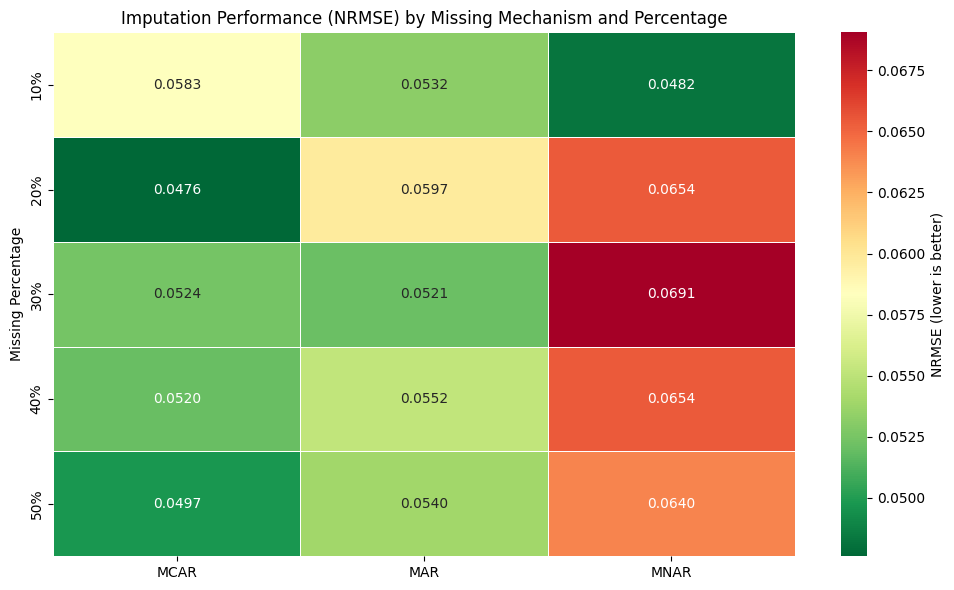

Line plot saved to models\2025-04-16_09-37-53_model-single\imputation_performance\imputation_performance_lineplot.png


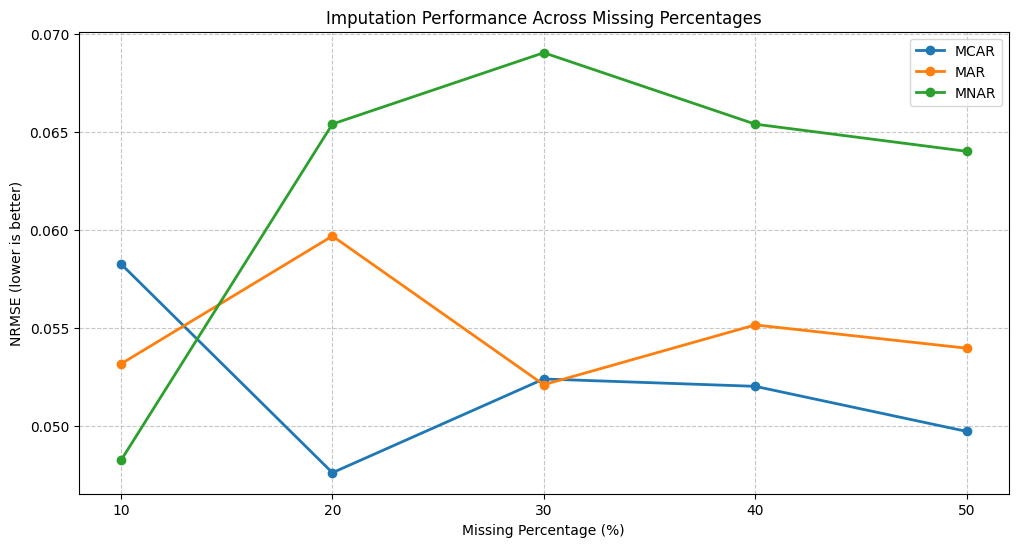

Bar chart saved to models\2025-04-16_09-37-53_model-single\imputation_performance\imputation_performance_barchart.png


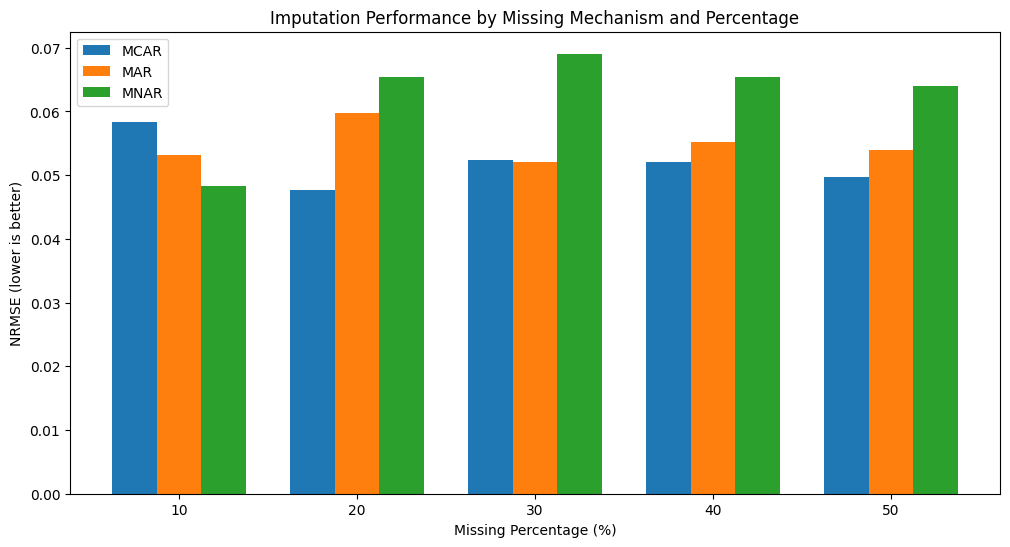

Table visualization saved to models\2025-04-16_09-37-53_model-single\imputation_performance\imputation_performance_table.png


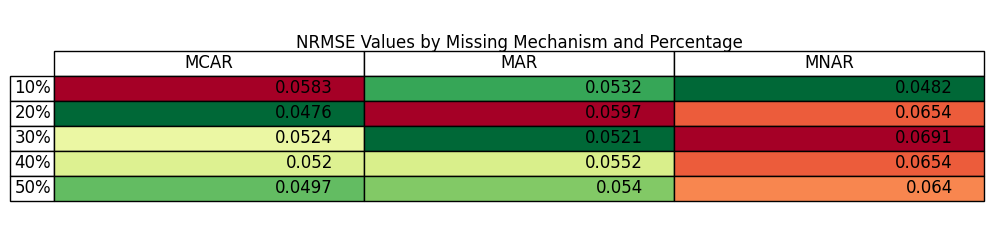


Imputation performance evaluation complete!


In [27]:
if __name__ == "__main__":
    # Create a section for imputation performance evaluation
    print("\n=== Evaluating Imputation Performance Across Missing Percentages ===")
    
    # Define the missing percentages to evaluate
    missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Create a directory for imputation performance visualizations
    imputation_dir = os.path.join(save_dir, "imputation_performance")
    os.makedirs(imputation_dir, exist_ok=True)
    
    # Evaluate imputation performance
    results_df = evaluate_imputation_performance(
        model,                    # Use the final trained model
        test_data,                # Test data
        column_indices,           # Column indices
        missing_percentages,      # Missing percentages
        mechanisms                # Missing mechanisms
    )
    
    # Save the raw results to CSV
    results_csv_path = os.path.join(imputation_dir, "imputation_results.csv")
    results_df.to_csv(results_csv_path)
    print(f"Raw imputation results saved to {results_csv_path}")
    
    # Create and save visualizations
    visualize_imputation_performance(
        results_df,
        save_path=os.path.join(imputation_dir, "imputation_performance.png")
    )
        
    print("\nImputation performance evaluation complete!")

## Impute the original dataset

In [28]:
def impute_original_dataset(trained_model, scaler, save_path="imputed_original.csv"):
    """
    Load the original CSV dataset, impute missing values using the pre-trained transformer model,
    and save the imputed dataset.
    
    Args:
        trained_model: The pre-trained imputation model
        scaler: The fitted scaler used during model training
        save_path: Path to save the imputed dataset
    """
    print("\n=== Imputing Original Dataset ===")
    
    # Set model to evaluation mode
    trained_model.eval()
    
    # File path
    original_file_path = "./data/physionet_39_features_only_no_leakage.csv"
    
    # Load the original dataset
    print(f"Loading original dataset from {original_file_path}...")
    df_original = pd.read_csv(original_file_path, index_col=None)
    print(f"Original dataset shape: {df_original.shape}")
    
    # Check for missing values
    missing_count = df_original.isna().sum().sum()
    missing_percentage = (missing_count / (df_original.shape[0] * df_original.shape[1])) * 100
    print(f"Dataset contains {missing_count} missing values ({missing_percentage:.2f}% of all values)")
    
    # Create a copy of the original dataset for imputation
    df_imputed = df_original.copy()
    
    # Extract numerical columns for imputation
    numerical_cols = df_original.select_dtypes(include=['number']).columns
    print(f"Found {len(numerical_cols)} numerical columns")
    
    # Create mask for missing values (True where values are missing)
    missing_mask = df_original[numerical_cols].isna()
    
    # Fill missing values with 0 for initial processing
    df_filled = df_original[numerical_cols].fillna(0)
    
    # Scale the data using the provided scaler
    data_scaled = scaler.transform(df_filled)
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices tensor
    column_indices = torch.arange(data_tensor.shape[1]).to(device)
    
    # Create mask tensor (1 where values are missing, 0 otherwise)
    mask_tensor = torch.tensor(missing_mask.values, dtype=torch.int).to(device)
    
    print("Performing imputation with trained model...")
    
    with torch.no_grad():
        # Get predictions from the model
        imputed_tensor = trained_model(data_tensor, column_indices, mask_tensor)
        
        # Convert to numpy for processing
        imputed_np = imputed_tensor.cpu().numpy()
        
        # Inverse transform to original scale
        imputed_np = scaler.inverse_transform(imputed_np)
        
        # Create a DataFrame from the imputed values
        imputed_df = pd.DataFrame(imputed_np, columns=numerical_cols, index=df_original.index)
        
        # Replace missing values in the original dataframe with imputed values
        for col in numerical_cols:
            if col in df_imputed.columns:
                missing_idx = df_imputed[col].isna()
                df_imputed.loc[missing_idx, col] = imputed_df.loc[missing_idx, col]
    
    # Save the imputed dataset
    print(f"Saving imputed dataset to {save_path}...")
    df_imputed.to_csv(save_path)
    
    # Verification
    missing_after = df_imputed[numerical_cols].isna().sum().sum()
    print(f"Missing values in numerical columns after imputation: {missing_after}")
    
    total_missing_after = df_imputed.isna().sum().sum()
    if total_missing_after > 0:
        print(f"Total missing values after imputation: {total_missing_after}")
        print("Note: Non-numerical columns may still contain missing values")
    else:
        print("All missing values have been successfully imputed")
    
    print("Imputation complete!")
    
    return df_imputed

In [29]:
# Execute the imputation process
if __name__ == "__main__":
    print("\n=== Running Imputation on Original Dataset ===")
    
    # Use the already trained model
    # Assuming 'model' and 'scaler' are the trained model and scaler from earlier in the notebook
    imputed_data = impute_original_dataset(model, scaler, "imputed_original.csv")
    
    # Display sample of the imputed data
    print("\nSample of imputed data:")
    print(imputed_data.head())


=== Running Imputation on Original Dataset ===

=== Imputing Original Dataset ===
Loading original dataset from ./data/physionet_39_features_only_no_leakage.csv...
Original dataset shape: (2008, 39)
Dataset contains 3063 missing values (3.91% of all values)
Found 39 numerical columns
Performing imputation with trained model...


c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Saving imputed dataset to imputed_original.csv...
Missing values in numerical columns after imputation: 0
All missing values have been successfully imputed
Imputation complete!

Sample of imputed data:
   verbal.response  eye.opening  movement  GCS  lactate.dehydrogenase  \
0                5            4         6   15             294.000000   
1                5            4         6   15             203.000000   
2                5            4         6   15             137.000000   
3                5            4         6   15             373.117371   
4                5            4         6   15             295.000000   

   glutamic.oxaloacetic.transaminase  globulin  total.bilirubin  \
0                          81.000000      23.8             18.3   
1                          21.000000      25.4             18.3   
2                           9.000000      27.7             11.9   
3                         180.774231      27.0             51.6   
4                       